In [1]:
import json
import pandas as pd
import numpy as np
import networkx as nx
import os
import shutil
import subprocess
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from zipfile import ZipFile
from filecmp import dircmp
import h2o
import sys

In [2]:
project_name = 'Dbeaver'
version_name = '21.1.0'

#project_name = 'Redisson'
#version_name = 'redisson-3.16.0'

n_cluster_divisible_arr = [5,7,10,15,20,25]
affinity_arr = ['euclidean', 'manhattan', 'cosine']
linkage_arr = ['complete', 'average', 'single']

n_cluster = 100
affinity = 'cosine'
linkage = 'single'

In [3]:
depends_dir = f'C:/Users/tanji/Desktop/SoftwareRemodularization/raw_depends/{project_name}/{project_name}_{version_name}.json'
rootdir = f'C:/Users/tanji/Desktop/SoftwareRemodularization/raw_sourcecode/{project_name}/{project_name}_{version_name}'

In [4]:
print(rootdir)

C:/Users/tanji/Desktop/SoftwareRemodularization/raw_sourcecode/Dbeaver/Dbeaver_21.1.0


In [5]:
full_dir_arr = []
for root, dirs, files in os.walk(rootdir):
    #print(root)
    #print(dirs)
    for element in files:
        if '.java' in element:
            dir_string = root + '\\' + element
            full_dir_arr.append(dir_string)

cluster_dict = {}
cluster_tree = {}


for element in full_dir_arr:
    element = element.split('\\')
    child = element[-1]
    parent = element[-2]
    cluster_tree[child] = parent

In [6]:
cluster_tree

{'NotNull.java': 'code',
 'Nullable.java': 'code',
 'ArgumentTokenizer.java': 'utils',
 'ArrayUtils.java': 'utils',
 'Base64.java': 'utils',
 'BeanUtils.java': 'utils',
 'ByteNumberFormat.java': 'utils',
 'CommonUtils.java': 'utils',
 'IntKeyMap.java': 'utils',
 'IOUtils.java': 'utils',
 'LongKeyMap.java': 'utils',
 'MimeType.java': 'utils',
 'Pair.java': 'utils',
 'SecurityUtils.java': 'utils',
 'StandardConstants.java': 'utils',
 'BOMInputStream.java': 'io',
 'ByteOrderMark.java': 'io',
 'ExtendedDateFormat.java': 'time',
 'SAXListener.java': 'xml',
 'SAXReader.java': 'xml',
 'XMLBuilder.java': 'xml',
 'XMLConstants.java': 'xml',
 'XMLException.java': 'xml',
 'XMLUtils.java': 'xml',
 'WMIConstants.java': 'service',
 'WMIDataType.java': 'service',
 'WMIException.java': 'service',
 'WMIObject.java': 'service',
 'WMIObjectAttribute.java': 'service',
 'WMIObjectElement.java': 'service',
 'WMIObjectMethod.java': 'service',
 'WMIObjectSink.java': 'service',
 'WMIObjectSinkStatus.java': 'se

In [7]:
len(cluster_tree)

4177

In [8]:
try:
    os.mkdir('raw_depends/' + project_name)
except:
    pass

command = 'cd C:/Users/tanji/Desktop/SoftwareRemodularization/depends-0.9.2 & ' + f"java -jar depends.jar java C:/Users/tanji/Desktop/SoftwareRemodularization/raw_sourcecode/{project_name}/{project_name}_{version_name}" +  f' ../raw_depends/{project_name}/{project_name}_{version_name}' 
print(command)
os.system(command)

cd C:/Users/tanji/Desktop/SoftwareRemodularization/depends-0.9.2 & java -jar depends.jar java C:/Users/tanji/Desktop/SoftwareRemodularization/raw_sourcecode/Dbeaver/Dbeaver_21.1.0 ../raw_depends/Dbeaver/Dbeaver_21.1.0


0

In [8]:
with open(depends_dir) as f:
    depends_results = json.load(f)
    index  = 0
    var_array = []
    print(len(depends_results['variables']))
    for value in depends_results['variables']:
        var_array.append([index, value.split('\\')[-1]])
        #print(index, value)
        index += 1

4189


In [9]:
with open(depends_dir) as f:
    depends_results = json.load(f)
    index  = 0
    var_array = []
    print(len(depends_results['variables']))
    print(len(depends_results['cells']))
    for value in depends_results['variables']:
        var_array.append([index, value.split('\\')[-1]])
        #print(index, value)
        index += 1

    var_df = pd.DataFrame(var_array)
    var_df.columns = ['index_val', 'name']

    feature_list = {}
    feature_index = 2
    for element in depends_results['cells']:
        #print(element)
        try:
            for a in element['values']:
                if a not in feature_list:
                    feature_list[a] = feature_index
                    feature_index += 1
                #print(a['Call'])


        except:
            pass

    feature_arr = []
    for element in depends_results['cells']:
        #print(array)
        array = [0] * (len(feature_list) + 2)
        values = dict(element['values'])
        #print(element)
        array[0] = element['src']
        array[1] = element['dest']
        for feature in feature_list:
            try:
                value = values[feature]
                array[feature_list[feature]] = value
            except:
                pass
        #print(array)
        feature_arr.append(array)

    feature_df = pd.DataFrame(feature_arr)
    col_names = ['src', 'dest']
    for element in feature_list:
        col_names.append(element)
    feature_df.columns = col_names

    feature_df['sum'] = feature_df.sum(axis=1) - feature_df['src'] - feature_df['dest']
    #G = nx.Graph()
    G = nx.path_graph(len(depends_results['variables']))
    for index, row in feature_df.iterrows():
        G.add_edge(row['src'], row['dest'], weight=row['sum'])

    adj_mat = nx.adjacency_matrix(G)
    adj_mat_df = pd.DataFrame(adj_mat.toarray())
    np.fill_diagonal(adj_mat_df.values, adj_mat_df.values.max())
    x = adj_mat_df.values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    adj_mat_df = pd.DataFrame(x_scaled)
    
    sum_dependency_df = nx.to_pandas_adjacency(G)
    sum_dependency_df['sum'] = sum_dependency_df.sum(axis=1)
    final_dependency_df = sum_dependency_df['sum']

4189
61570


In [10]:
final_dependency_df

0       3855.0
1       2500.0
2          5.0
3        768.0
4         46.0
         ...  
4184      90.0
4185      43.0
4186     265.0
4187      39.0
4188       1.0
Name: sum, Length: 4189, dtype: float64

In [11]:
adj_mat_df

,0,1,2,3,4,5,6,7,8,9,...,4179,4180,4181,4182,4183,4184,4185,4186,4187,4188
0,1.000000,0.001802,0.000000,0.005405,0.000000,0.001802,0.000000,0.041441,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.005405,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.001802,1.000000,0.001802,0.001802,0.000000,0.003604,0.000000,0.010811,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.001802,1.000000,0.001802,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.005405,0.001802,0.001802,1.000000,0.001802,0.000000,0.000000,0.010811,0.0,0.0,...,0.0,0.0,0.0,0.142342,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.001802,1.000000,0.001802,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4184,0.000000,0.000000,0.000000,0.000000,0.000000,0.158559,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.001802,1.000000,0.001802,0.000000,0.000000,0.000000
4185,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.073874,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.001802,1.000000,0.001802,0.000000,0.000000
4186,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.473874,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.001802,1.000000,0.001802,0.000000
4187,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.001802,1.000000,0.001802


In [12]:
feature_df

,src,dest,Import,Call,Use,Contain,Create,Annotation,Cast,Extend,Implement,Parameter,Return,Throw,sum
0,3810,4033,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,3810,4034,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,3810,4031,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,3810,4032,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,211,2122,1.0,1.0,6.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61565,1180,2119,1.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7.0
61566,1267,1260,1.0,5.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0
61567,3661,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
61568,1267,1266,0.0,3.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,7.0


In [13]:
try:
    os.mkdir('MoJo_1.2.1/' + project_name)
except:
    pass

In [14]:
ck_metrics = pd.read_csv(f'ck_results_invi/{project_name}_{version_name}_class.csv')
ck_metrics['class_name'] = ck_metrics['file'].str.split('\\').str[-1]
ck_metrics['file'] = ck_metrics['file'].str.replace(r'E:\\', r'C:\\Users\\tanji\\Desktop\\',regex=True)
ck_metrics

,file,class,type,cbo,wmc,dit,rfc,lcom,totalMethods,staticMethods,...,assignmentsQty,mathOperationsQty,variablesQty,maxNestedBlocks,anonymousClassesQty,subClassesQty,lambdasQty,uniqueWordsQty,modifiers,class_name
0,C:\Users\tanji\Desktop\SoftwareRemodularizatio...,org.jkiss.utils.ArgumentTokenizer,class,1,34,1,14,3,3,3,...,26,3,16,4,0,0,0,107,1025,ArgumentTokenizer.java
1,C:\Users\tanji\Desktop\SoftwareRemodularizatio...,org.jkiss.utils.ArrayUtils,class,11,60,1,16,253,23,23,...,25,15,22,2,0,0,0,55,1,ArrayUtils.java
2,C:\Users\tanji\Desktop\SoftwareRemodularizatio...,org.jkiss.utils.Base64,class,3,57,1,9,0,11,11,...,135,87,60,3,0,0,0,68,17,Base64.java
3,C:\Users\tanji\Desktop\SoftwareRemodularizatio...,org.jkiss.utils.BeanUtils,class,4,95,1,47,251,23,23,...,37,13,30,4,0,0,0,110,1,BeanUtils.java
4,C:\Users\tanji\Desktop\SoftwareRemodularizatio...,org.jkiss.utils.ByteNumberFormat,class,2,16,3,7,22,8,1,...,19,3,14,3,0,0,0,93,1,ByteNumberFormat.java
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4161,C:\Users\tanji\Desktop\SoftwareRemodularizatio...,org.jkiss.utils.BOMInputStreamTest,class,7,6,1,9,6,4,2,...,7,0,6,2,0,0,0,32,1,BOMInputStreamTest.java
4162,C:\Users\tanji\Desktop\SoftwareRemodularizatio...,org.jkiss.utils.ByteNumberFormatTest,class,2,2,1,3,0,2,0,...,7,28,7,0,0,0,0,15,1,ByteNumberFormatTest.java
4163,C:\Users\tanji\Desktop\SoftwareRemodularizatio...,org.jkiss.utils.CommonUtilsTest,class,7,64,1,92,2016,64,0,...,32,0,32,0,0,0,0,116,1,CommonUtilsTest.java
4164,C:\Users\tanji\Desktop\SoftwareRemodularizatio...,org.jkiss.utils.MimeTypeTest,class,4,2,1,8,1,2,0,...,1,0,1,0,0,0,0,10,1,MimeTypeTest.java


In [90]:
cluster = AgglomerativeClustering(n_clusters=n_cluster, affinity=affinity, linkage=linkage)
cluster_result = cluster.fit_predict(adj_mat_df)

#ck_metrics = pd.read_csv(f'ck_results_invi/{project_name}_{version_name}_class.csv')
#ck_metrics['class_name'] = ck_metrics['file'].str.split('\\').str[-1]
filename_a = 'C:/Users/tanji/Desktop/SoftwareRemodularization/MoJo_1.2.1/' + project_name + '/' + project_name + '_' + version_name + '_' + str(n_cluster) + '_' +str(affinity) + '_' + str(linkage) + '_a.rsf'
filename_b = 'C:/Users/tanji/Desktop/SoftwareRemodularization/MoJo_1.2.1/' + project_name + '/' + project_name + '_' + version_name + '_' + str(n_cluster) + '_' +str(affinity) + '_' + str(linkage) + '_b.rsf'

with open(filename_a, 'w') as f:
    for key, value in cluster_tree.items():
        f.write('contain ' + str(value).replace(" ",'') + ' ' + str(key).replace(' ','') + '\n')

arr_a_rsf = []
arr_b_rsf = []
with open(filename_b, 'w') as f:
    len_b_rsf = 0
    duplicate_array = []
    refactor_arr = []
    main_data_arr = []
    clustering_result_dict = {}
    num_line_affected = 0
    num_dependency = 0
    actual_num_of_classes_touched = 0
    for i in range(len(cluster_result)):
        try:
            subject = var_df[var_df['index_val'] == i]['name'].values[0]
            #print(subject)
            #print(subject in cluster_tree)
            if subject in cluster_tree and subject not in duplicate_array:
                #print(element)
                duplicate_array.append(subject)
                string = "contain " + str(cluster_result[i]) + " " + subject + "\n"
                arr_b_rsf.append(subject)
                len_b_rsf += 1
                f.write(string)
                #print(subject)
                class_metrics = ck_metrics.loc[ck_metrics['class_name'] == subject].values.tolist()[0]
                
                #print(ck_metrics.loc[ck_metrics['class_name'] == subject]['file'].values[0])
                
                subjected_file = ck_metrics.loc[ck_metrics['class_name'] == subject]['file'].values[0]
                
                #print(subjected_file)
                
                num_dependency = final_dependency_df.iloc[cluster_result[i]]
                num_line_affected += sum(1 for line in open(subjected_file))
                
                
                class_metrics.append(num_dependency)
                class_metrics.append(num_line_affected)
                
                main_data_arr.append(class_metrics)
                
                
                ## Important
                ## This is assuming that during Depends, the file structure is already sorted
                ## I.e. going through the directory structure depth wise, not breath wise
                original_parent = cluster_tree[subject]
                try:
                    to_check_parent = clustering_result_dict[cluster_result[i]]
                    #print(original_parent, to_check_parent)
                    if original_parent != to_check_parent:
                        refactor_arr.append(f'Move {subject} to {str(cluster_result[i])}')
                    
                    clustering_result_dict[cluster_result[i]] = to_check_parent
                except:
                    clustering_result_dict[cluster_result[i]] = original_parent
                
            else:
                #print(subject)
                pass
        except Exception as e:
            print(e)
            exc_type, exc_obj, exc_tb = sys.exc_info()
            fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
            print(exc_type, fname, exc_tb.tb_lineno)
            pass
f.close()

command = 'cd C:/Users/tanji/Desktop/SoftwareRemodularization/MoJo_1.2.1 & ' + 'java MoJo ' + filename_a + ' ' + filename_b + ' >> ' + project_name + '/' + project_name + '_results.txt'
#print(command)
os.system(command)

list index out of range
<class 'IndexError'> <ipython-input-90-5588b80fa683> 37
list index out of range
<class 'IndexError'> <ipython-input-90-5588b80fa683> 37
list index out of range
<class 'IndexError'> <ipython-input-90-5588b80fa683> 37
list index out of range
<class 'IndexError'> <ipython-input-90-5588b80fa683> 37
list index out of range
<class 'IndexError'> <ipython-input-90-5588b80fa683> 37
list index out of range
<class 'IndexError'> <ipython-input-90-5588b80fa683> 37
list index out of range
<class 'IndexError'> <ipython-input-90-5588b80fa683> 37
list index out of range
<class 'IndexError'> <ipython-input-90-5588b80fa683> 37
list index out of range
<class 'IndexError'> <ipython-input-90-5588b80fa683> 37
list index out of range
<class 'IndexError'> <ipython-input-90-5588b80fa683> 37
list index out of range
<class 'IndexError'> <ipython-input-90-5588b80fa683> 37
list index out of range
<class 'IndexError'> <ipython-input-90-5588b80fa683> 37
list index out of range
<class 'IndexErr

0

In [91]:
print(len(refactor_arr))
refactor_arr

4029


['Move BOMInputStream.java to 0',
 'Move ByteOrderMark.java to 0',
 'Move ExtendedDateFormat.java to 0',
 'Move SAXListener.java to 0',
 'Move SAXReader.java to 0',
 'Move XMLBuilder.java to 0',
 'Move XMLConstants.java to 0',
 'Move XMLException.java to 0',
 'Move XMLUtils.java to 0',
 'Move WMIConstants.java to 0',
 'Move WMIException.java to 0',
 'Move WMIObject.java to 0',
 'Move WMIObjectAttribute.java to 0',
 'Move WMIObjectElement.java to 0',
 'Move WMIObjectMethod.java to 0',
 'Move WMIObjectSink.java to 0',
 'Move WMIQualifiedObject.java to 0',
 'Move WMIQualifier.java to 0',
 'Move WMIService.java to 0',
 'Move CompareObjectsHandler.java to 0',
 'Move CompareObjectsPageOutput.java to 0',
 'Move CompareObjectsPageSettings.java to 0',
 'Move CompareObjectsWizard.java to 0',
 'Move CompareWizardDialog.java to 0',
 'Move CompareObjectsExecutor.java to 0',
 'Move CompareObjectsSettings.java to 0',
 'Move CompareReport.java to 0',
 'Move CompareReportLine.java to 0',
 'Move Compare

In [92]:
temp_dataframe = pd.DataFrame(main_data_arr)
temp_columns = list(ck_metrics.columns)
temp_columns.append('num_dependency')
temp_columns.append('num_line_affected')
temp_dataframe.columns = temp_columns

## For the groupby operation below
temp_dataframe['placeholder_key'] = 'placeholder_key'

In [93]:
temp_dataframe.head()

,file,class,type,cbo,wmc,dit,rfc,lcom,totalMethods,staticMethods,...,maxNestedBlocks,anonymousClassesQty,subClassesQty,lambdasQty,uniqueWordsQty,modifiers,class_name,num_dependency,num_line_affected,placeholder_key
0,C:\Users\tanji\Desktop\SoftwareRemodularizatio...,org.jkiss.utils.ArgumentTokenizer,class,1,34,1,14,3,3,3,...,4,0,0,0,107,1025,ArgumentTokenizer.java,3855.0,227,placeholder_key
1,C:\Users\tanji\Desktop\SoftwareRemodularizatio...,org.jkiss.utils.ArrayUtils,class,11,60,1,16,253,23,23,...,2,0,0,0,55,1,ArrayUtils.java,3855.0,473,placeholder_key
2,C:\Users\tanji\Desktop\SoftwareRemodularizatio...,org.jkiss.utils.Base64,class,3,57,1,9,0,11,11,...,3,0,0,0,68,17,Base64.java,3855.0,803,placeholder_key
3,C:\Users\tanji\Desktop\SoftwareRemodularizatio...,org.jkiss.utils.BeanUtils,class,4,95,1,47,251,23,23,...,4,0,0,0,110,1,BeanUtils.java,3855.0,1208,placeholder_key
4,C:\Users\tanji\Desktop\SoftwareRemodularizatio...,org.jkiss.utils.ByteNumberFormat,class,2,16,3,7,22,8,1,...,3,0,0,0,93,1,ByteNumberFormat.java,3855.0,1374,placeholder_key


In [94]:
project_refactoring_data_agg = temp_dataframe.groupby(['placeholder_key'], as_index=False).agg({
       'cbo': ['mean', 'min', 'max','std'], 
        'wmc': ['mean', 'min', 'max','std'], 
        'dit': ['mean', 'min', 'max','std'], 
        'rfc': ['mean', 'min', 'max','std'], 
        'lcom': ['mean', 'min', 'max','std'],
        'totalMethods': ['mean', 'min', 'max','std'], 
        'staticMethods': ['mean', 'min', 'max','std'],
        'publicMethods': ['mean', 'min', 'max','std'], 
        'privateMethods': ['mean', 'min', 'max','std'],
        'protectedMethods': ['mean', 'min', 'max','std'], 
        'defaultMethods': ['mean', 'min', 'max','std'], 
        'abstractMethods': ['mean', 'min', 'max','std'], 
        'finalMethods': ['mean', 'min', 'max','std'],
        'synchronizedMethods': ['mean', 'min', 'max','std'],
        'totalFields': ['mean', 'min', 'max','std'], 
        'staticFields': ['mean', 'min', 'max','std'], 
        'publicFields': ['mean', 'min', 'max','std'],
        'privateFields': ['mean', 'min', 'max','std'],
        'protectedFields': ['mean', 'min', 'max','std'],
        'defaultFields': ['mean', 'min', 'max','std'], 
        'finalFields': ['mean', 'min', 'max','std'],
        'synchronizedFields': ['mean', 'min', 'max','std'],
        'nosi': ['mean', 'min', 'max','std'], 
        'loc': ['mean', 'min', 'max','std'], 
        'returnQty': ['mean', 'min', 'max','std'],
        'loopQty': ['mean', 'min', 'max','std'],
        'comparisonsQty': ['mean', 'min', 'max','std'],
        'tryCatchQty': ['mean', 'min', 'max','std'],
        'parenthesizedExpsQty': ['mean', 'min', 'max','std'],
        'stringLiteralsQty': ['mean', 'min', 'max','std'],
        'numbersQty': ['mean', 'min', 'max','std'], 
        'assignmentsQty': ['mean', 'min', 'max','std'],
        'mathOperationsQty': ['mean', 'min', 'max','std'], 
        'variablesQty': ['mean', 'min', 'max','std'], 
        'maxNestedBlocks': ['mean', 'min', 'max','std'],
        'anonymousClassesQty': ['mean', 'min', 'max','std'],
        'subClassesQty': ['mean', 'min', 'max','std'],
        'lambdasQty': ['mean', 'min', 'max','std'],
        'uniqueWordsQty': ['mean', 'min', 'max','std'],
        'modifiers': ['mean', 'min', 'max','std'],
        'num_dependency': ['mean'],
        'num_line_affected': ['mean']
})

In [95]:
project_refactoring_data_agg

placeholder_key        cbo                            wmc           \
                         mean min  max        std       mean min  max   
0  placeholder_key  11.687696   0  232  13.628536  16.490489   0  811   

                  dit  ... uniqueWordsQty                      modifiers      \
        std      mean  ...           mean min  max        std       mean min   
0  34.36582  2.161329  ...      50.480857   0  784  49.973487  77.589453   0   

                    num_dependency num_line_affected  
    max         std           mean              mean  
0  1025  269.112314    3770.790754     274458.981218  

[1 rows x 163 columns]

In [96]:
columns_to_agg = [
    'cbo', 'wmc', 'dit', 'rfc', 'lcom',
       'totalMethods', 'staticMethods', 'publicMethods', 'privateMethods',
       'protectedMethods', 'defaultMethods', 'abstractMethods', 'finalMethods',
       'synchronizedMethods', 'totalFields', 'staticFields', 'publicFields',
       'privateFields', 'protectedFields', 'defaultFields', 'finalFields',
       'synchronizedFields', 'nosi', 'loc', 'returnQty', 'loopQty',
       'comparisonsQty', 'tryCatchQty', 'parenthesizedExpsQty',
       'stringLiteralsQty', 'numbersQty', 'assignmentsQty',
       'mathOperationsQty', 'variablesQty', 'maxNestedBlocks',
       'anonymousClassesQty', 'subClassesQty', 'lambdasQty', 'uniqueWordsQty',
       'modifiers'
]


project_refactoring_data_agg_column_names = ['placeholder_key']
for element in columns_to_agg:
    project_refactoring_data_agg_column_names.append(element + '_mean')
    project_refactoring_data_agg_column_names.append(element + '_min')
    project_refactoring_data_agg_column_names.append(element + '_max')
    project_refactoring_data_agg_column_names.append(element + '_std')
    
    
project_refactoring_data_agg_column_names.append('num_dependency_mean')
project_refactoring_data_agg_column_names.append('num_line_affected_mean')

In [97]:
project_refactoring_data_agg.columns = project_refactoring_data_agg_column_names

In [98]:
project_refactoring_data_agg

,placeholder_key,cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,dit_mean,...,uniqueWordsQty_mean,uniqueWordsQty_min,uniqueWordsQty_max,uniqueWordsQty_std,modifiers_mean,modifiers_min,modifiers_max,modifiers_std,num_dependency_mean,num_line_affected_mean
0,placeholder_key,11.687696,0,232,13.628536,16.490489,0,811,34.36582,2.161329,...,50.480857,0,784,49.973487,77.589453,0,1025,269.112314,3770.790754,274458.981218


In [99]:
#project_refactoring_data_agg['wmc_max'] = 10000
#project_refactoring_data_agg['wmc_max']

In [100]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,3 hours 59 mins
H2O_cluster_timezone:,Asia/Kuala_Lumpur
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.7
H2O_cluster_version_age:,3 months and 15 days !!!
H2O_cluster_name:,H2O_from_python_tanji_eafnu9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.868 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [101]:
#model_path = "models/EffortEstimationModelv2/GBM_5_AutoML_20211120_201618"
model_path = "models/EffortEstimationModelv2/GBM_3_AutoML_20211218_094109"
saved_model = h2o.load_model(model_path)

In [102]:
project_refactoring_data_agg.drop(['placeholder_key'],axis=1, inplace=True)

In [103]:
project_refactoring_data_agg

,cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,dit_mean,dit_min,...,uniqueWordsQty_mean,uniqueWordsQty_min,uniqueWordsQty_max,uniqueWordsQty_std,modifiers_mean,modifiers_min,modifiers_max,modifiers_std,num_dependency_mean,num_line_affected_mean
0,11.687696,0,232,13.628536,16.490489,0,811,34.36582,2.161329,1,...,50.480857,0,784,49.973487,77.589453,0,1025,269.112314,3770.790754,274458.981218


In [104]:
prediction_df = h2o.H2OFrame(project_refactoring_data_agg)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [105]:
prediction_df

cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,dit_mean,dit_min,dit_max,dit_std,rfc_mean,rfc_min,rfc_max,rfc_std,lcom_mean,lcom_min,lcom_max,lcom_std,totalMethods_mean,totalMethods_min,totalMethods_max,totalMethods_std,staticMethods_mean,staticMethods_min,staticMethods_max,staticMethods_std,publicMethods_mean,publicMethods_min,publicMethods_max,publicMethods_std,privateMethods_mean,privateMethods_min,privateMethods_max,privateMethods_std,protectedMethods_mean,protectedMethods_min,protectedMethods_max,protectedMethods_std,defaultMethods_mean,defaultMethods_min,defaultMethods_max,defaultMethods_std,abstractMethods_mean,abstractMethods_min,abstractMethods_max,abstractMethods_std,finalMethods_mean,finalMethods_min,finalMethods_max,finalMethods_std,synchronizedMethods_mean,synchronizedMethods_min,synchronizedMethods_max,synchronizedMethods_std,totalFields_mean,totalFields_min,totalFields_max,totalFields_std,staticFields_mean,staticFields_min,staticFields_max,staticFields_std,publicFields_mean,publicFields_min,publicFields_max,publicFields_std,privateFields_mean,privateFields_min,privateFields_max,privateFields_std,protectedFields_mean,protectedFields_min,protectedFields_max,protectedFields_std,defaultFields_mean,defaultFields_min,defaultFields_max,defaultFields_std,finalFields_mean,finalFields_min,finalFields_max,finalFields_std,synchronizedFields_mean,synchronizedFields_min,synchronizedFields_max,synchronizedFields_std,nosi_mean,nosi_min,nosi_max,nosi_std,loc_mean,loc_min,loc_max,loc_std,returnQty_mean,returnQty_min,returnQty_max,returnQty_std,loopQty_mean,loopQty_min,loopQty_max,loopQty_std,comparisonsQty_mean,comparisonsQty_min,comparisonsQty_max,comparisonsQty_std,tryCatchQty_mean,tryCatchQty_min,tryCatchQty_max,tryCatchQty_std,parenthesizedExpsQty_mean,parenthesizedExpsQty_min,parenthesizedExpsQty_max,parenthesizedExpsQty_std,stringLiteralsQty_mean,stringLiteralsQty_min,stringLiteralsQty_max,stringLiteralsQty_std,numbersQty_mean,numbersQty_min,numbersQty_max,numbersQty_std,assignmentsQty_mean,assignmentsQty_min,assignmentsQty_max,assignmentsQty_std,mathOperationsQty_mean,mathOperationsQty_min,mathOperationsQty_max,mathOperationsQty_std,variablesQty_mean,variablesQty_min,variablesQty_max,variablesQty_std,maxNestedBlocks_mean,maxNestedBlocks_min,maxNestedBlocks_max,maxNestedBlocks_std,anonymousClassesQty_mean,anonymousClassesQty_min,anonymousClassesQty_max,anonymousClassesQty_std,subClassesQty_mean,subClassesQty_min,subClassesQty_max,subClassesQty_std,lambdasQty_mean,lambdasQty_min,lambdasQty_max,lambdasQty_std,uniqueWordsQty_mean,uniqueWordsQty_min,uniqueWordsQty_max,uniqueWordsQty_std,modifiers_mean,modifiers_min,modifiers_max,modifiers_std,num_dependency_mean,num_line_affected_mean
11.6877,0,232,13.6285,16.4905,0,811,34.3658,2.16133,1,41,1.82929,15.2764,0,593,27.8196,77.1623,0,19110,619.95,7.74982,0,209,12.501,0.544667,0,171,4.33141,5.62533,0,203,10.9514,0.647484,0,75,2.38239,0.724055,0,28,1.8219,0.00024079,0,1,0.0155174,0.0512882,0,10,0.404716,0.00818685,0,4,0.125813,0.0493619,0,14,0.373393,4.33566,0,428,13.9034,2.0171,0,428,13.1245,1.45148,0,428,13.0262,2.63352,0,79,4.99552,0.0972791,0,14,0.637368,0,0,0,0,1.73947,0,184,7.1307,0,0,0,0,4.82759,0,223,11.1903,98.2333,3,3940,172.214,5.987,0,237,12.4286,0.982422,0,64,3.12257,1.67806,0,120,5.30729,0.763063,0,47,2.34237,0.864435,0,77,3.33309,6.52757,0,587,23.6142,3.79966,0,427,13.9242,11.9738,0,832,27.2095,1.51818,0,230,6.97465,9.96749,0,428,21.6068,1.21406,-1,13,2.01683,0.323621,0,19,1.28323,0.173128,-1,19,1.00199,0.267517,0,42,1.27464,50.4809,0,784,49.9735,77.5895,0,1025,269.112,3770.79,274459


In [106]:
preds = saved_model.predict(prediction_df)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [107]:
print(preds[0])

predict
5.30624


In [119]:
pd_pred = preds.as_data_frame()
pd_pred.iloc[0]['predict']

5.306244256650032

In [118]:
print("Final Predicted Time: " + str(pd_pred.iloc[0]['predict'] * len(refactor_arr)/11))

Final Predicted Time: 1943.5325554584526


# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

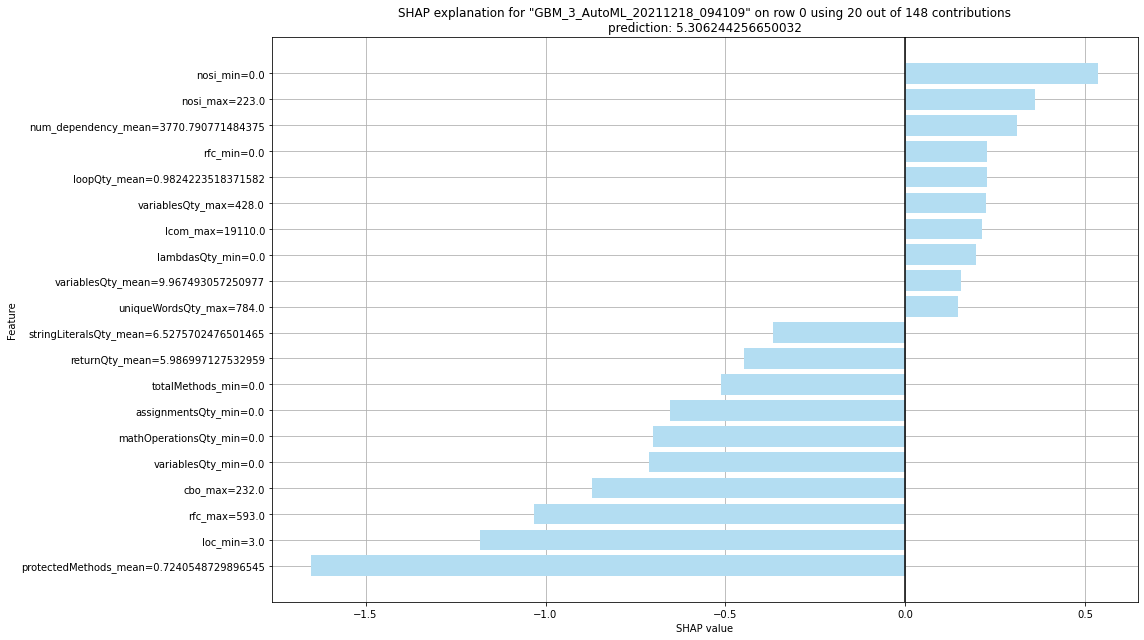

# Individual Conditional Expectation

> Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

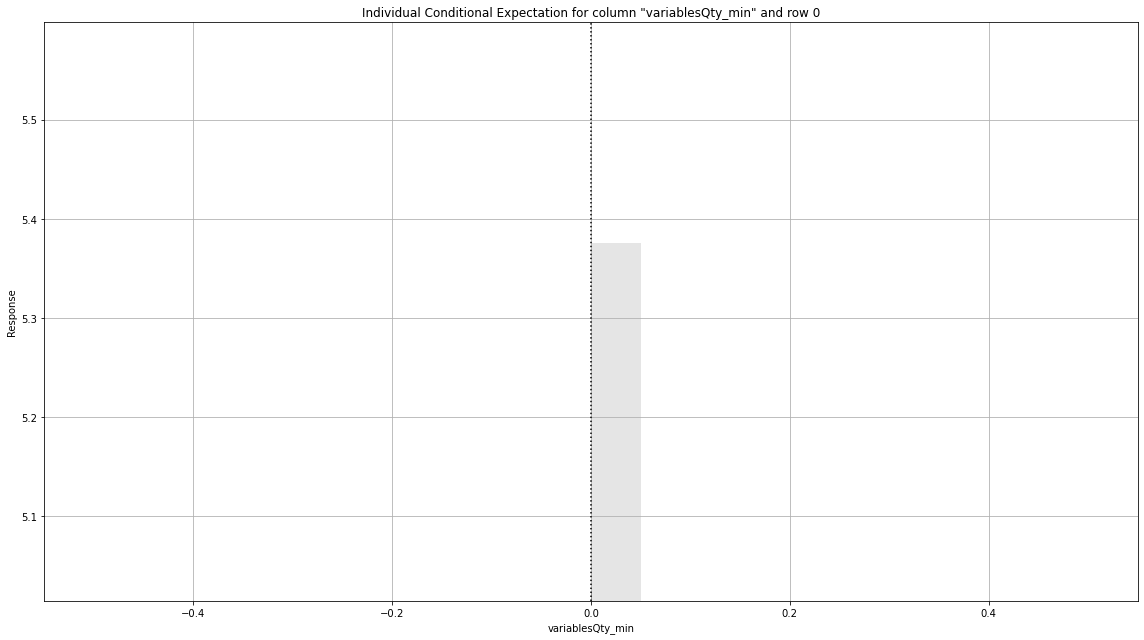

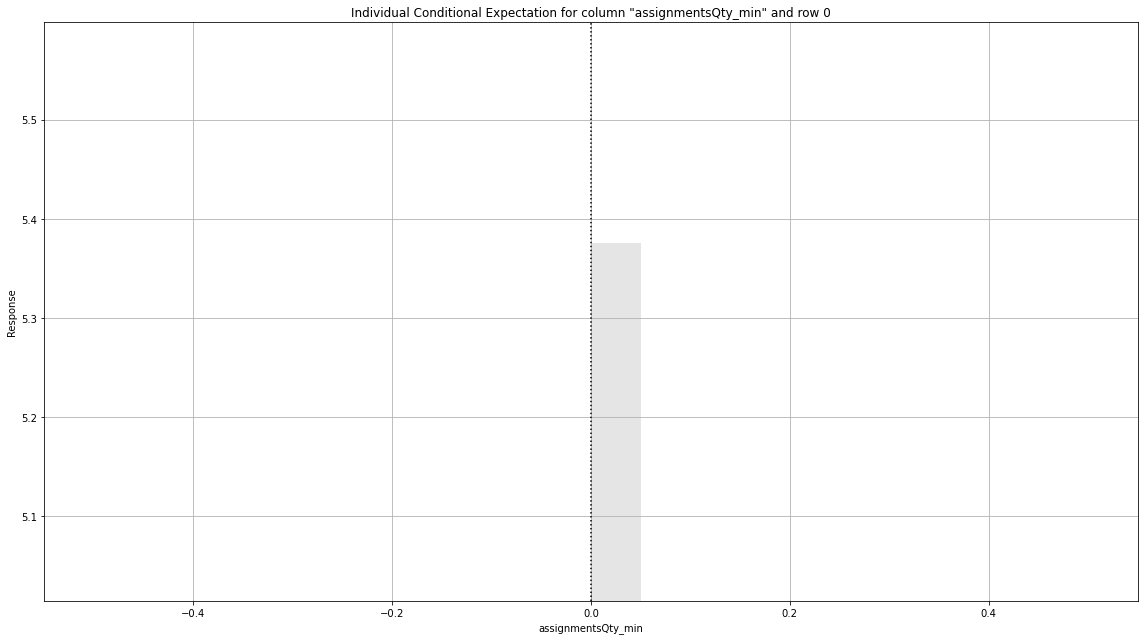

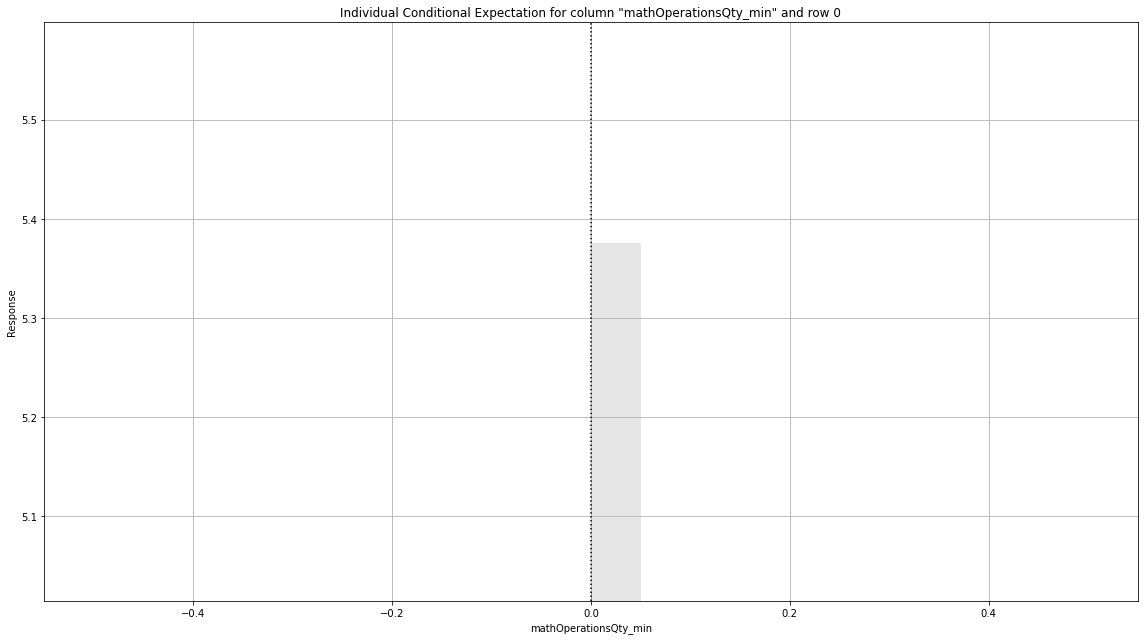

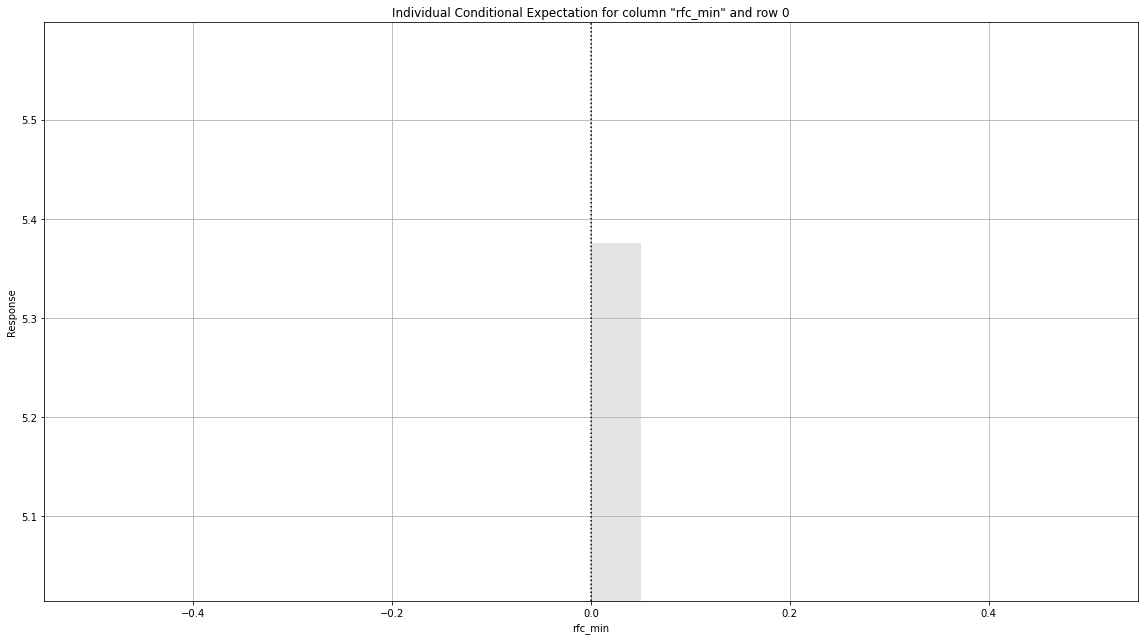

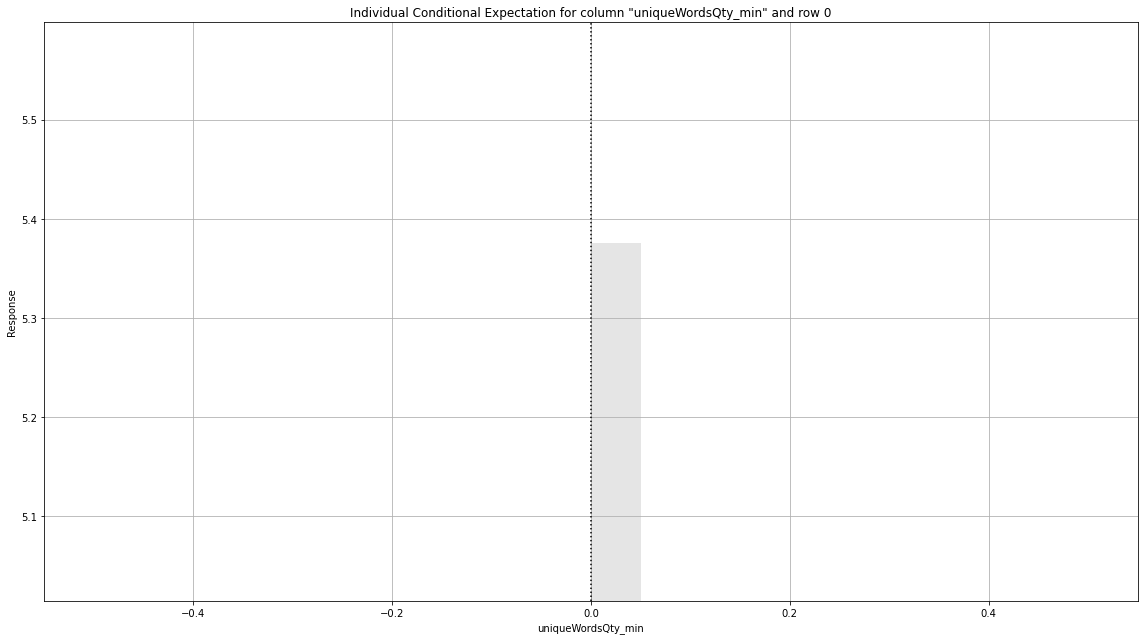

In [109]:
final_df = prediction_df
final_df['refactoring_perc_time_taken'] = preds[0]
exm = saved_model.explain_row(prediction_df, row_index=0)

In [ ]:
refactor_arr

In [150]:
saved_model

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_1_AutoML_20211125_152544


GLM Model: summary


,,family,link,regularization,lambda_search,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,gaussian,identity,Ridge ( lambda = 15.561 ),"nlambda = 30, lambda.max = 703.43, lambda.min = 15.561, lambda.1se...",153,153,13,automl_training_py_6_sid_bd1a




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 782.7144852913913
RMSE: 27.97703496247219
MAE: 18.158385363805124
RMSLE: 1.4200762405657579
R^2: 0.053181589282774944
Mean Residual Deviance: 782.7144852913913
Null degrees of freedom: 253
Residual degrees of freedom: 100
Null deviance: 209976.3555647517
Residual deviance: 198809.47926401338
AIC: 2723.1638436837934

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 801.6948318040318
RMSE: 28.31421607256736
MAE: 18.48058510116557
RMSLE: NaN
R^2: 0.030221823164136352
Mean Residual Deviance: 801.6948318040318
Null degrees of freedom: 253
Residual degrees of freedom: 102
Null deviance: 210509.699745404
Residual deviance: 203630.48727822406
AIC: 2725.249693594421

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,18.479473,1.7476318,18.184616,20.428413,19.464485,15.767283,18.552565
1,mean_residual_deviance,798.9942,200.19315,797.7754,994.5134,994.3213,540.84607,667.51495
2,mse,798.9942,200.19315,797.7754,994.5134,994.3213,540.84607,667.51495
3,null_deviance,42101.94,10696.866,42505.09,52736.63,52123.25,28236.047,34908.684
4,r2,0.028139917,0.016799217,0.04259261,0.0382267,0.0078622755,0.011902851,0.040115148
5,residual_deviance,40615.203,10323.186,40686.547,50720.184,50710.387,27583.15,33375.746
6,rmse,28.081219,3.6123714,28.244919,31.535908,31.532862,23.256098,25.83631
7,rmsle,1.3573587,0.0030857364,1.3549855,NaN,1.3562437,1.360847,NaN



Scoring History: 


,,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_xval,deviance_se,alpha,iterations,training_rmse,training_deviance,training_mae,training_r2
0,,2021-11-25 15:25:44,0.000 sec,1,.7E3,154,823.419641,825.678612,92.828596,0.0,NaN,,,,
1,,2021-11-25 15:25:44,0.001 sec,2,.51E3,154,822.297609,824.785196,92.833202,0.0,NaN,,,,
2,,2021-11-25 15:25:44,0.002 sec,3,.37E3,154,820.834759,823.619924,92.836298,0.0,NaN,,,,
3,,2021-11-25 15:25:44,0.002 sec,4,.27E3,154,818.956528,822.123972,92.834760,0.0,NaN,,,,
4,,2021-11-25 15:25:44,0.003 sec,5,.2E3,154,816.596089,820.246967,92.823052,0.0,NaN,,,,
5,,2021-11-25 15:25:44,0.004 sec,6,.14E3,154,813.707403,817.962249,92.791447,0.0,NaN,,,,
6,,2021-11-25 15:25:44,0.004 sec,7,.1E3,154,810.283824,815.288921,92.724436,0.0,NaN,,,,
7,,2021-11-25 15:25:44,0.005 sec,8,.76E2,154,806.364515,812.314883,92.599889,0.0,NaN,,,,
8,,2021-11-25 15:25:44,0.006 sec,9,.55E2,154,802.036204,809.207946,92.386910,0.0,NaN,,,,
9,,2021-11-25 15:25:44,0.007 sec,10,.4E2,154,797.420935,806.214493,92.049630,0.0,NaN,,,,



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,maxNestedBlocks_max,0.269557,1.000000,0.028207
1,maxNestedBlocks_mean,0.210727,0.781753,0.022051
2,totalFields_mean,0.168841,0.626364,0.017668
3,modifiers_std,0.166467,0.617558,0.017419
4,maxNestedBlocks_min,0.164213,0.609196,0.017183
5,privateFields_mean,0.146784,0.544538,0.015360
6,totalFields_max,0.144130,0.534691,0.015082
7,totalFields_min,0.142252,0.527724,0.014885
8,finalFields_mean,0.137994,0.511931,0.014440
9,lambdasQty_mean,0.137637,0.510606,0.014402



See the whole table with table.as_data_frame()


In [107]:
test_df = pd.read_csv('test_effort_model.csv')

In [108]:
test_df.head()

,sha,name,email,date,login,message,parent_sha,parent_date,time_taken,contains_refactoring,...,num_dependency_std,num_line_affected_mean,num_line_affected_min,num_line_affected_max,num_line_affected_std,actual_num_of_classes_touched_mean,actual_num_of_classes_touched_min,actual_num_of_classes_touched_max,actual_num_of_classes_touched_std,time_taken_final
0,6ad1e4fe77445e8689f6d3975b26e52165c9c3e6,Bin Fan,fanbin103@gmail.com,2021-08-04 02:49:16,apc999,Fix IndexOutOfBoundsException on async cache\n...,df5dcab8bc308dfd2bf650a895865b13120a9866,2021-08-03 16:07:28,10.0,1,...,0.000000,764.000000,764,764,0.000,9.0,9,9,0.000000,10.0
1,8647c6162423b851dda8d10edf4686473d2e95cc,Zac Blanco,zac@alluxio.com,2021-07-15 21:54:27,ZacBlanco,Update and improve conformance of S3 API\n\n##...,79a5e5c78b7dfcdbf8edbd928a2ff59c904d08f8,2021-07-15 18:38:50,3.0,1,...,0.000000,275.000000,275,275,0.000,6.0,6,6,0.000000,3.0
2,3ce52983e6f50bfb7880b5a2cb13a18e4272170b,Zhan Yuan,yuanzhanhku@gmail.com,2021-07-12 06:39:42,yuanzhanhku,Add CacheContext to URIStatus to enable per-re...,cf79c7837c57c83c1b99a1dab53fec25deb2069d,2021-07-10 20:58:13,33.0,1,...,0.000000,115.000000,115,115,0.000,4.5,3,6,2.121320,33.0
3,a4dc54f7dc0333da096aa779dbaa79060c90d1ad,kqhzz,kuangqinghuazz@163.com,2021-06-09 18:09:26,kuszz,Deprecate leader command\n\nFix #13512\n\npr-l...,1356c0b35fd753d1081665b2c8f6b25da62bf2e8,2021-06-09 02:31:45,15.0,1,...,0.000000,61.000000,61,61,0.000,2.0,2,2,0.000000,15.0
4,7fb84094a6075bcef5a103b40adcac4b26b724ca,Jiacheng Liu,jiacheliu3@gmail.com,2021-05-29 00:37:05,jiacheliu3,Refactor MasterWorkerInfo\n\nCurrently all the...,220237085593d731756e24249bcf88a4d6ea5710,2021-05-28 23:28:46,1.0,1,...,93.543216,458.666667,24,1245,682.248,35.0,1,54,29.512709,1.0


In [109]:
test_df.drop(columns=['sha',
'name','email','login',
'date','message',
'parent_sha','parent_date',
'time_taken','contains_refactoring',
'kmean_label','mean',
'min','max',
'project_name','commit_compared_with','actual_num_of_classes_touched_mean',
 'actual_num_of_classes_touched_min',
 'actual_num_of_classes_touched_max',
 'actual_num_of_classes_touched_std','time_taken_final']
             ,inplace=True)

In [110]:
test_df

,cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,dit_mean,dit_min,...,modifiers_max,modifiers_std,num_dependency_mean,num_dependency_min,num_dependency_max,num_dependency_std,num_line_affected_mean,num_line_affected_min,num_line_affected_max,num_line_affected_std
0,38.000000,38.0,38.0,0.000000,57.00,57.0,57.0,0.000000,1.000000,1.0,...,17.0,0.000000,322.000000,322.0,322.0,0.000000,764.000000,764,764,0.000000
1,12.000000,12.0,12.0,0.000000,17.00,17.0,17.0,0.000000,1.000000,1.0,...,1.0,0.000000,15.000000,15.0,15.0,0.000000,275.000000,275,275,0.000000
2,4.000000,4.0,4.0,0.000000,15.00,15.0,15.0,0.000000,1.000000,1.0,...,1.0,0.000000,371.000000,371.0,371.0,0.000000,115.000000,115,115,0.000000
3,11.000000,11.0,11.0,0.000000,8.00,8.0,8.0,0.000000,2.000000,2.0,...,17.0,0.000000,85.000000,85.0,85.0,0.000000,61.000000,61,61,0.000000
4,27.666667,3.0,76.0,41.860881,50.00,1.0,140.0,78.044859,1.666667,1.0,...,1.0,0.000000,69.333333,8.0,177.0,93.543216,458.666667,24,1245,682.248000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,77.000000,77.0,77.0,0.000000,260.00,260.0,260.0,0.000000,4.000000,4.0,...,17.0,0.000000,11.000000,11.0,11.0,0.000000,3932.000000,3932,3932,0.000000
362,11.250000,7.0,22.0,6.692213,24.00,4.0,54.0,22.309511,1.500000,1.0,...,17.0,8.552360,105.000000,4.0,321.0,137.772068,217.500000,67,566,217.340418
363,8.500000,2.0,17.0,5.680376,13.25,7.0,19.0,4.753946,1.250000,1.0,...,17.0,0.447214,53.000000,5.0,143.0,58.052849,117.500000,31,198,61.085732
364,7.000000,7.0,7.0,0.000000,2.00,2.0,2.0,0.000000,1.000000,1.0,...,1.0,0.000000,42.000000,42.0,42.0,0.000000,18.000000,18,18,0.000000


In [111]:
prediction_df = h2o.H2OFrame(test_df)
preds = saved_model.predict(prediction_df)

Parse progress: |█████████████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


In [112]:
preds

predict
8.80149
17.1904
18.8304
19.1618
6.99672
17.551
17.0801
16.6316
13.7009
13.3708


In [115]:
len(preds)

366

In [116]:
pd_preds = preds.as_data_frame()

In [117]:
pd_preds['predict'].value_counts()

18.775940    2
16.259852    2
4.799652     2
20.734580    2
20.558679    2
            ..
20.994492    1
14.732429    1
18.621463    1
15.743354    1
8.801486     1
Name: predict, Length: 361, dtype: int64